# Solving the Ground State of Hamiltonian by Imaginary-time Evolution

## Overview

Imaginary-time evolution (IME) is a method to solve the ground state of the Hamiltonian, which is more efficient than naive gradient descent and will not fall into a local minimum.

However, exact imaginary-time evolution takes exponentially more space and time to execute on a classical computer. On the other hand, it is non-unitary and also cannot be implemented on a quantum computer. Therefore, we consider the approximate imaginary-time evolution, also known as the quantum natural gradient (QNG), that is, at each step we adjust the parameters in the quantum circuit to realize the imaginary-time evolution in a very short time $\tau$. Let the parameters in the circuit be $\boldsymbol{\theta}$ and the output of the circuit is $|\psi\rangle$, define
$$
\begin{eqnarray}
    |\psi_\tau\rangle&=&e^{-\tau\hat{H}}|\psi\rangle\approx|\psi\rangle-\tau\hat{H}|\psi\rangle,\\
    |\psi'\rangle&=&|\psi(\boldsymbol{\theta}-\tau\boldsymbol{\delta})\rangle\approx|\psi\rangle-\tau\sum_j\boldsymbol{\delta}_j|\partial_{\boldsymbol{\theta}_{j}}\psi\rangle,
\end{eqnarray}
$$
and the overlap is
$$
\begin{equation}
    O=\sqrt{\frac{\langle\psi_\tau\rangle|\psi'\rangle\langle\psi'|\psi_\tau\rangle}{\langle\psi_\tau\rangle|\psi_\tau\rangle\langle\psi'|\psi'\rangle}}.
\end{equation}
$$
Let $\partial|O|^2/\partial\boldsymbol{\delta}=0$, we can get $\boldsymbol{A\delta=C}$, then the update method is as follows
$$
\begin{equation}
    \boldsymbol{\theta}^{n+1}=\boldsymbol{\theta}^{n}-\tau\boldsymbol{\delta}=\boldsymbol{\theta}^{n}-\tau\boldsymbol{A}^{-1}\boldsymbol{C},
\end{equation}
$$
where $\boldsymbol{A}$ is the quantum Fisher information matrix and the matrix element
$$
\begin{equation}
    \boldsymbol{A}_{ij}=\Re\left[\frac{\langle\partial_{\boldsymbol{\theta}_{i}}\psi|\partial_{\boldsymbol{\theta}_{j}}\psi\rangle}{\langle\psi|\psi\rangle}-\frac{\langle\partial_{\boldsymbol{\theta}_{i}}\psi|\psi\rangle}{\langle\psi|\psi\rangle}\frac{\langle\psi|\partial_{\boldsymbol{\theta}_{j}}\psi\rangle}{\langle\psi|\psi\rangle}\right];
\end{equation}
$$
$\boldsymbol{C}$ is the gradient vector of energy versus parameters and the vector element
$$
\begin{equation}
    \boldsymbol{C}_j=\Re\left[\frac{\langle\psi|\hat{H}|\partial_{\boldsymbol{\theta}_{j}}\psi\rangle}{\langle\psi|\psi\rangle}-\frac{\langle\psi|\hat{H}|\psi\rangle}{\langle\psi|\psi\rangle}\frac{\langle\psi|\partial_{\boldsymbol{\theta}_{j}}\psi\rangle}{\langle\psi|\psi\rangle}\right].
\end{equation}
$$
Since $|\psi\rangle$ is represented by quantum circuit and naturally normalized, the second term of $\boldsymbol{C}$ vanishes. And because the global phase is not important, we can add a $U(1)$ gauge to make the second term of $\boldsymbol{A}$ vanishes. Related theoretical work can refer to [Yuan, Endo, Zhao, Li and Benjamin](https://doi.org/10.22331/q-2019-10-07-191) and [Stokes, Izaac, Killoran and Carleo](https://doi.org/10.22331/q-2020-05-25-269), which will also show how to measure $\boldsymbol{A}$ and $\boldsymbol{C}$ in circuit.

In fields other than quantum computation, equivalent forms of imaginary-time evolution are stochastic reconfiguration in variational Monte Carlo method and natural gradient method and Gauss-Newton method in classical optimization. In stochastic reconfiguration, $|\psi\rangle$ is not normalized, so $\boldsymbol{A}$ and $\boldsymbol{C}$ are the form shown above. In classical optimization, the second terms of $\boldsymbol{A}$ and $\boldsymbol{C}$ vanish automatically when the output is the classical probability distribution. Therefore, when $|\psi\rangle$ is similar to the classical probability distribution, that is, when there is no sign structure and phase information, the second term of $\boldsymbol{A}$ will automatically vanish.

In this tutorial, we solve a classical Hamiltonian and a quantum Hamiltonian by the approximate imaginary-time evolution and demonstrate various forms of code implementation.

In [ ]:
import tensorcircuit as tc
from tensorcircuit import experimental
import optax
import jax.numpy as jnp
import tensorflow as tf
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import cotengra as ctg
import time
from functools import partial
from IPython.display import clear_output

K = tc.set_backend('jax')
tc.set_dtype("complex128")

# cotengra package to speed up the calculation
opt_ctg = ctg.ReusableHyperOptimizer(
    methods = ["greedy", "kahypar"],
    parallel = True,
    minimize = "combo",
    max_time = 20,
    max_repeats = 128,
    progbar = True
)

tc.set_contractor("custom", optimizer=opt_ctg, preprocessing=True)

## Classical Hamiltonian

The classical Hamiltonian is the Hamiltonian of NAE3SAT, which can be solved by QAOA. Please refer to the tutorial of [QAOA for NAE3SAT](qaoa_nae3sat.ipynb) for details.

Let the set of clauses in the NAE3SAT be $\mathcal{C}$. In each clause, there are three literals and each literal is represented by a spin. Spins up ($s=1$, $\text{bit}=0$) and down ($s=-1$, $\text{bit}=1$) represent false and true respectively. For the clause $(s_i,\ s_j,\ s_k)\in\mathcal{C}$, $s_i,\ s_j,\ s_k$ cannot be 1 or -1 at the same time. The Hamiltonian of the NAE3SAT is as follows
$$
\begin{equation}
    \begin{split}
        \hat{H}_C&=\sum_{(i,j,k)\in\mathcal{C}}\left[(s_i+s_j+s_k)^2-1\right]/2\\
        &=\sum_{(i,j,k)\in\mathcal{C}}(s_i s_j+s_j s_k+s_k s_i)+|\mathcal{C}|,
    \end{split}
\end{equation}
$$
where $|\mathcal{C}|$ is the number of clauses in $\mathcal{C}$. When all clauses are true, $\hat{H}_C$ takes the minimum value 0, and the corresponding bit string is the solution of the NAE3SAT.

### Define the Hamiltonian

We select the hard problem in the tutorial of [QAOA for NAE3SAT](qaoa_nae3sat.ipynb). We first construct the graph by the clauses.

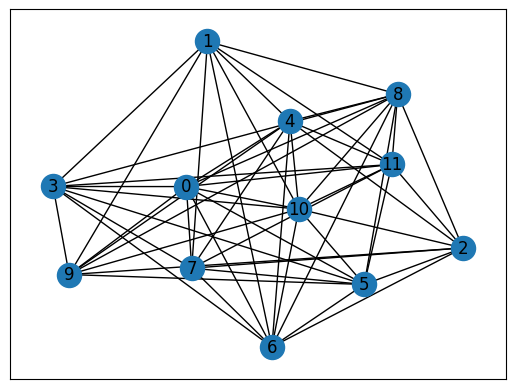

In [3]:
# a classical Hamiltonian instance
clauses = [[4, 1, 7], [5, 11, 8], [4, 1, 8], [4, 11, 8], [4, 1, 10], [5, 11, 8], [4, 1, 8], [1, 11, 8], [4, 1, 7], [0, 11, 8], [4, 1, 10], [4, 11, 8], [5, 0, 10], [0, 6, 7], [5, 0, 11], [0, 6, 7], [5, 0, 9], [3, 6, 7], [5, 0, 8], [5, 6, 7], [5, 0, 10], [3, 6, 7], [5, 0, 10], [1, 6, 7], [2, 4, 6], [1, 8, 11], [2, 4, 6], [2, 8, 11], [2, 4, 9], [5, 8, 11], [2, 4, 10], [2, 8, 11], [2, 4, 10], [4, 8, 11], [2, 4, 8], [4, 8, 11], [3, 0, 9], [5, 11, 7], [3, 0, 10], [2, 11, 7], [3, 0, 9], [0, 11, 7], [3, 0, 9], [5, 11, 7], [3, 0, 10], [3, 11, 7], [3, 0, 7], [4, 11, 7], [5, 0, 10], [4, 0, 10], [2, 5, 6], [2, 11, 10], [2, 6, 10], [2, 4, 9], [0, 9, 10], [3, 0, 7], [2, 5, 6], [1, 10, 9], [1, 4, 11], [5, 10, 11], [0, 4, 8], [0, 9, 8], [2, 11, 10], [2, 8, 6], [3, 6, 7], [0, 8, 10], [4, 0, 9], [3, 5, 8], [5, 11, 10], [2, 11, 10], [4, 11, 8], [1, 3, 11]]
factor = 1 / len(clauses) / 4

# convert to a NetworkX graph
graph = nx.Graph()
for i, j, k in clauses:
    graph.add_edge(i, j, weight=0)
    graph.add_edge(j, k, weight=0)
    graph.add_edge(k, i, weight=0)
for i, j, k in clauses:
    graph[i][j]['weight'] += 1
    graph[j][k]['weight'] += 1
    graph[k][i]['weight'] += 1
pos = nx.spring_layout(graph)
nx.draw_networkx(graph, with_labels=True, pos=pos)
ax = plt.gca()
ax.set_facecolor('w')

Then we construct the Hamiltonian from the graph.

In [4]:
def b2s(bit):
    return 1 - 2 * int(bit)

def energy(cfg):
    E = 0.25
    for a, b in graph.edges:
        E += cfg[a] * cfg[b] * graph[a][b]['weight'] * factor
    return E

def construct_Ham():
    num_nodes = graph.number_of_nodes()
    Es = []
    for i in range(2 ** num_nodes):
        case = f'{bin(i)[2:]:0>{num_nodes}}'
        Es.append(energy(list(map(b2s, case))))
    return jnp.asarray(Es)

Hv = construct_Ham()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Here we calculate $e^{-\tau\hat{H}}$ in advance to perform exact imaginary-time evolution for comparison with approximate imaginary-time evolution.

In [5]:
tau_c = 0.025
exp_tauHv = K.exp(-tau_c * Hv)

### Variational wave function

Here we choose regular QAOA ansatz as the parameterized quantum circuit ([PQC](https://tensorcircuit.readthedocs.io/en/latest/textbook/chap5.html?highlight=变分)).

In [6]:
nlayers = 20  # the number of layers

@partial(K.jit, static_argnums=(1, 2))
def wfn_classical(params, each=1, return_loss=False):
    n = graph.number_of_nodes()  # the number of nodes

    # PQC loop
    def pqc_loop(s_, params_):
        c_ = tc.Circuit(n, inputs=s_)
        for j in range(each):
            # driving layer
            for a, b in graph.edges:
                c_.RZZ(a, b, theta=graph[a][b]['weight'] * params_[2 * j] * factor)
            # mixing layer
            for i in range(n):
                c_.RX(i, theta=params_[2 * j + 1])
        s_ = c_.state()
        return s_

    c0 = tc.Circuit(n)
    for i in range(n):
        c0.H(i)
    s0 = c0.state()
    s = K.scan(pqc_loop, K.reshape(params, [nlayers // each, 2 * each]), s0)
    c = tc.Circuit(n, inputs=s)

    if return_loss:
        loss = 0.25
        for a, b in graph.edges:
            loss += c.expectation_ps(z=[a, b]) * graph[a][b]['weight'] * factor
        return K.real(loss)
    else:
        return c.state()

### Optimization

We use two methods to calculate $\boldsymbol{\delta}$, one is to calculate directly according to the expressions of $\boldsymbol{A}$ and $\boldsymbol{C}$, and the other is to call the existing API to calculate $\boldsymbol{A}$ and $\boldsymbol{C}$. The former only needs to calculate the $|\partial_{\boldsymbol{\theta}_{j}}\psi\rangle$ once, while the latter needs to calculate that twice, but the code of the latter is more concise. In each method, we set the parameter $\text{fixed_global_phase}$ to decide whether to fix the global phase, that is, whether the second term of $\boldsymbol{A}$ vanishes.

Then we choose the existing optimizer, SGD, to implement the update step. Since compared with naive gradient descent, the approximate imaginary-time evolution has been corrected on the update step size, the adaptive optimizer improved for the naive gradient descent such as Adam is not suitable for the approximate imaginary-time evolution. When update by the adaptive optimizer, the loss function fluctuates greatly. On the other hand, the update method of SGD without momentum is naive update, which is convenient for comparison with the exact imaginary-time evolution.

In [7]:
@partial(K.jit, static_argnums=(3,))
def d_params(params, psi, eps=1e-6, fixed_global_phase=False):
    psi = psi[:, None]
    psiHT = K.conj(K.transpose(psi))
    par_psi = K.jacfwd(wfn_classical, argnums=0)
    jac = par_psi(params)
    jacHT = K.conj(K.transpose(jac))

    A = K.real(jacHT @ jac)
    if not fixed_global_phase:
        A -= K.real(jacHT @ psi @ psiHT @ jac)
    # protection
    A += eps * K.eye(params.shape[-1], dtype=A.dtype)

    C = K.real((psiHT * Hv) @ jac)[0]

    return K.solve(A, C, assume_a="sym")

@partial(K.jit, static_argnums=(2,))
def d_params_api(params, eps=1e-6, fixed_global_phase=False):
    if fixed_global_phase:
        qng = experimental.qng(wfn_classical, kernel="dynamics", postprocess=None, mode="fwd")
    else:
        qng = experimental.qng(wfn_classical, kernel="qng", postprocess=None, mode="fwd")
    A = K.real(qng(params))
    # protection
    A += eps * K.eye(params.shape[-1], dtype=A.dtype)

    vag = K.value_and_grad(partial(wfn_classical, return_loss=True), argnums=0)
    loss, C2 = vag(params)

    return loss, K.solve(A, C2 / 2, assume_a="sym")

if K.name == 'jax':
    opt = K.optimizer(optax.sgd(tau_c))
else:
    opt = K.optimizer(tf.keras.optimizers.SGD(tau_c))

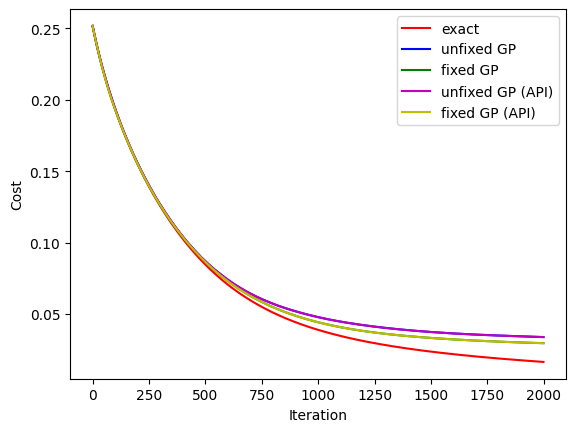

Epoch 1999: 6.1109702587127686	Total: 12327.309196949005


In [8]:
steps_classical = 2000

# initial parameters
params = K.implicit_randn(shape=(2 * nlayers,), stddev=0.1)
params_fgp = K.copy(params)
params_api = K.copy(params)
params_fgp_api = K.copy(params)
psi_exact = wfn_classical(params)

losses, losses_fgp, losses_exact = [], [], []
losses_api, losses_fgp_api = [], []

eps = 1e-6
t0 = ts = time.time()

for i in range(steps_classical):
    psi = wfn_classical(params)
    loss = K.real(K.tensordot(K.conj(psi) * Hv, psi, 1))
    delta = d_params(params, psi, eps)
    params = opt.update(delta, params)
    losses.append(K.numpy(loss))

    psi_fgp = wfn_classical(params_fgp)
    loss_fgp = K.real(K.tensordot(K.conj(psi_fgp) * Hv, psi_fgp, 1))
    delta_fgp = d_params(params_fgp, psi_fgp, eps, fixed_global_phase=True)
    params_fgp = opt.update(delta_fgp, params_fgp)
    losses_fgp.append(K.numpy(loss_fgp))

    loss_api, delta_api = d_params_api(params_api, eps)
    params_api = opt.update(delta_api, params_api)
    losses_api.append(K.numpy(loss_api))

    loss_fgp_api, delta_fgp_api = d_params_api(params_fgp_api, eps, fixed_global_phase=True)
    params_fgp_api = opt.update(delta_fgp_api, params_fgp_api)
    losses_fgp_api.append(K.numpy(loss_fgp_api))

    loss_exact = K.real(K.tensordot(K.conj(psi_exact) * Hv, psi_exact, 1))
    psi_exact *= exp_tauHv
    psi_exact /= K.norm(psi_exact)
    losses_exact.append(K.numpy(loss_exact))

    eps *= 0.999

    # visualise the progress
    clear_output(wait=True)
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.plot(range(i + 1), losses_exact, c='r', label='exact')
    plt.plot(range(i + 1), losses, c='b', label='unfixed GP')
    plt.plot(range(i + 1), losses_fgp, c='g', label='fixed GP')
    plt.plot(range(i + 1), losses_api, c='m', label='unfixed GP (API)')
    plt.plot(range(i + 1), losses_fgp_api, c='y', label='fixed GP (API)')
    plt.legend()
    plt.show()

    te = time.time()
    print(f'Epoch {i}: {te - ts}\tTotal: {te - t0}')
    ts = te

### Results

We first show the overlap between the final states obtained by different methods. The final states obtained by different methods but with the same parameter of $\text{fixed_global_phase}$ are almost the same, which are also close to the exact final state. And the final states obtained by the same method but with the different parameter of $\text{fixed_global_phase}$ has a global phase difference.

In [9]:
psi = wfn_classical(params)
psi_fgp = wfn_classical(params_fgp)
psi_api = wfn_classical(params_api)
psi_fgp_api = wfn_classical(params_fgp_api)

overlap = K.tensordot(K.conj(psi_fgp), psi, 1)
print(f'overlap between psi_fgp and psi\n|overlap|: {K.abs(overlap)}\noverlap: {overlap}\n')
overlap = K.tensordot(K.conj(psi_fgp_api), psi_api, 1)
print(f'overlap between psi_fgp_api and psi_api\n|overlap|: {K.abs(overlap)}\noverlap: {overlap}\n')
overlap = K.tensordot(K.conj(psi_api), psi, 1)
print(f'overlap between psi_api and psi\n|overlap|: {K.abs(overlap)}\noverlap: {overlap}\n')
overlap = K.tensordot(K.conj(psi_fgp_api), psi_fgp, 1)
print(f'overlap between psi_fgp_api and psi_fgp\n|overlap|: {K.abs(overlap)}\noverlap: {overlap}\n')
overlap = K.tensordot(K.conj(psi_exact), psi, 1)
print(f'overlap between psi_exact and psi\n|overlap|: {K.abs(overlap)}\noverlap: {overlap}\n')
overlap = K.tensordot(K.conj(psi_exact), psi_fgp, 1)
print(f'overlap between psi_exact and psi_fgp\n|overlap|: {K.abs(overlap)}\noverlap: {overlap}\n')
overlap = K.tensordot(K.conj(psi_exact), psi_api, 1)
print(f'overlap between psi_exact and psi_api\n|overlap|: {K.abs(overlap)}\noverlap: {overlap}\n')
overlap = K.tensordot(K.conj(psi_exact), psi_fgp_api, 1)
print(f'overlap between psi_exact and psi_fgp_api\n|overlap|: {K.abs(overlap)}\noverlap: {overlap}')

overlap between psi_fgp and psi
|overlap|: 0.9184369993048669
overlap: (-0.4580633040968157+0.7960556080651879j)

overlap between psi_fgp_api and psi_api
|overlap|: 0.9184279183739732
overlap: (-0.4588479071459403+0.7955931368209131j)

overlap between psi_api and psi
|overlap|: 0.999999996801054
overlap: (0.999999545918014-0.0009496135391365943j)

overlap between psi_fgp_api and psi_fgp
|overlap|: 0.9999999922593946
overlap: (0.9999999907968652+5.408381530766986e-05j)

overlap between psi_exact and psi
|overlap|: 0.8876639929202528
overlap: (-0.45130602703961775+0.7643757153944926j)

overlap between psi_exact and psi_fgp
|overlap|: 0.9290015132797724
overlap: (0.9278995939751679-0.04523444679473629j)

overlap between psi_exact and psi_api
|overlap|: 0.8876569548840061
overlap: (-0.45202998890392976+0.7639396302624046j)

overlap between psi_exact and psi_fgp_api
|overlap|: 0.9290084278770248
overlap: (0.9279048483224752-0.04526865942553761j)


Then we show the exact solution by the brutal force method.

min cost: 0.0
exact solution: ['000000111111', '111111000000']


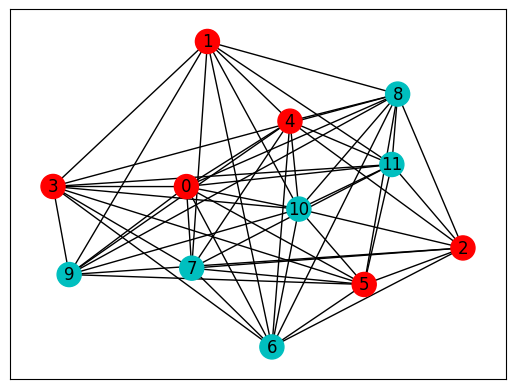

In [10]:
idx = [f'{bin(i)[2:]:0>{graph.number_of_nodes()}}' for i in np.where(Hv < 1e-6)[0]]
print(f'min cost: {0.}\nexact solution: {idx}')

# plot NetworkX graph
colors = ['r' if idx[0][i] == '0' else 'c' for i in graph.nodes]
nx.draw_networkx(graph, with_labels=True, node_color=colors, pos=pos)
ax = plt.gca()
ax.set_facecolor('w')

Then we use the bit string with the maximum probability as the approximate solution since we know all information of the probability distribution of the output quantum state, but which is not feasible in the experiment. For the hard problem with rough energy landscape, approximate imaginary-time evolution with 20-layer ansatz gives mediocre results, similar to those obtained by the Adam optimizer with 30-layer ansatz, which can be found in the tutorial of [QAOA for NAE3SAT](qaoa_nae3sat.ipynb). However, this does not mean that approximate imaginary-time evolution is more practical than Adam optimizer because under the same ansatz, the former consumes much more time for each step update than the latter. In contrast, the exact imaginary-time evolution gives excellent results but takes exponential time to compute on a classical computer.

In [11]:
loss = K.real(K.tensordot(K.conj(psi) * Hv, psi, 1))
loss_fgp = K.real(K.tensordot(K.conj(psi_fgp) * Hv, psi_fgp, 1))
loss_api = K.real(K.tensordot(K.conj(psi_api) * Hv, psi_api, 1))
loss_fgp_api = K.real(K.tensordot(K.conj(psi_fgp_api) * Hv, psi_fgp_api, 1))
loss_exact = K.real(K.tensordot(K.conj(psi_exact) * Hv, psi_exact, 1))
print(f'cost by exact IME: {K.numpy(loss_exact)}')
print(f'cost: {K.numpy(loss)}\t{K.numpy(loss_fgp)} (fgp)')
print(f'cost (API): {K.numpy(loss_api)}\t{K.numpy(loss_fgp_api)} (fgp)\n')

# find the states with max probabilities
def find_max(psi):
    probs = K.numpy(K.real(K.conj(psi) * psi))
    max_prob = max(probs)
    index = np.where(probs == max_prob)[0]
    states = []
    for i in index:
        states.append(f'{bin(i)[2:]:0>{graph.number_of_nodes()}}')
    return max_prob, states

prob, states = find_max(psi)
prob_fpg, states_fpg = find_max(psi_fgp)
prob_api, states_api = find_max(psi_api)
prob_fpg_api, states_fpg_api = find_max(psi_fgp_api)
prob_exact, states_exact = find_max(psi_exact)
print(f'max prob by exact IME: {prob_exact}')
print(f'max prob: {prob}\t{prob_fpg} (fgp)')
print(f'max prob (API): {prob_api}\t{prob_fpg_api} (fgp)\n')
print(f'bit strings by exact IME: {states_exact}')
print(f'bit strings: {states}\t{states_fpg} (fgp)')
print(f'bit strings (API): {states_api}\t{states_fpg_api} (fgp)')

cost by exact IME: 0.01636900218695893
cost: 0.03377396891545763	0.02951298530564577 (fgp)
cost (API): 0.033775089880425574	0.0295121140061756 (fgp)

max prob by exact IME: 0.13847431901217763
max prob: 0.03930045644879558	0.05100224184204695 (fgp)
max prob (API): 0.03929777441862845	0.05100594691342963 (fgp)

bit strings by exact IME: ['111111000000']
bit strings: ['111111000000']	['000000111111'] (fgp)
bit strings (API): ['000000111111']	['111111000000'] (fgp)


## Quantum Hamiltonian

The quantum Hamiltonian is the Hamiltonian of the transverse and longitudinal field Ising model.

### Define the Hamiltonian

Here we also calculate $e^{-\tau\hat{H}}$ in advance to perform exact imaginary-time evolution for comparison with approximate imaginary-time evolution.

In [13]:
N = 10
g = tc.templates.graphs.Line1D(N, pbc=False)
h = tc.quantum.heisenberg_hamiltonian(g, hzz=1, hyy=0, hxx=0, hz=0.5, hx=1, hy=0, sparse=True)
H = tc.array_to_tensor(h.todense())

tau_q = 0.001
exp_tauH = K.expm(-tau_q * H)

### Variational wave function

Compared with the regular QAOA ansatz in the classic example, this ansatz has a higher parameter density and the initial state is $|0\rangle$ instead of $|+\rangle$.

In [14]:
l = 10   # the number of layers

@partial(K.jit, static_argnums=(1,))
def wfn_quantum(theta, each=1):
    # PQC loop
    def pqc_loop(s_, theta_):
        c_ = tc.Circuit(N, inputs=s_)
        for i in range(each):
            for j in range(N):
                c_.RZZ(j, (j + 1) % N, theta=theta_[i, j, 0])
            for j in range(N):
                c_.RX(j, theta=theta_[i, j, 1])
        s_ = c_.state()
        return s_

    c0 = tc.Circuit(N)
    s0 = c0.state()
    s = K.scan(pqc_loop, K.reshape(theta, [l // each, each, N, 2]), s0)
    c = tc.Circuit(N, inputs=s)

    return c.state()

### Optimization

We also use two methods to calculate $\boldsymbol{\delta}$, but make some changes in the method of directly calling the API and the update method. When calculating $\boldsymbol{A}$, we call $\text{qng2}$ instead of $\text{qng}$, and when calculating $\boldsymbol{C}$, we call $\text{dynamics_rhs}$ instead of calculating the energy gradient by $\text{value_and_grad}$. For the update method, we do not call the existing optimizer but directly adopt the naive update method.

In [15]:
@partial(K.jit, static_argnums=(3,))
def d_theta(theta, psi, eps=1e-6, fixed_global_phase=False):
    psi = psi[:, None]
    psiHT = K.conj(K.transpose(psi))
    par_psi = K.jacfwd(wfn_quantum, argnums=0)
    jac = par_psi(theta)
    jacHT = K.conj(K.transpose(jac))

    A = K.real(jacHT @ jac)
    if not fixed_global_phase:
        A -= K.real(jacHT @ psi @ psiHT @ jac)
    # protection
    A += eps * K.eye(theta.shape[-1], dtype=A.dtype)

    C = K.real(psiHT @ K.sparse_dense_matmul(h, jac))[0]

    return K.solve(A, C, assume_a="sym")

@partial(K.jit, static_argnums=(2,))
def d_theta_api(theta, eps=1e-6, fixed_global_phase=False):
    if fixed_global_phase:
        qng = experimental.qng2(wfn_quantum, kernel="dynamics", postprocess=None, mode="fwd")
    else:
        qng = experimental.qng2(wfn_quantum, kernel="qng", postprocess=None, mode="fwd")
    A = K.real(qng(theta))
    # protection
    A += eps * K.eye(theta.shape[-1], dtype=A.dtype)

    vag = experimental.dynamics_rhs(wfn_quantum, h)
    C = vag(theta)

    return K.solve(A, C, assume_a="sym")

@K.jit
def update(theta, delta, tau):
    return theta - K.cast(tau * delta, dtype=theta.dtype)

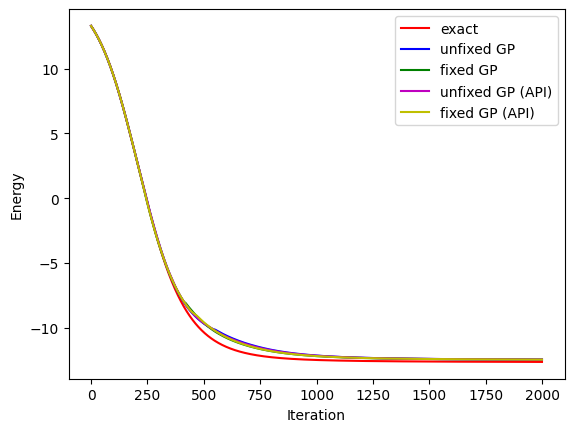

Epoch 1999: 0.9534459114074707	Total: 1922.968999862671


In [16]:
steps_quantum = 2000

# initial parameters
theta = K.implicit_randn(shape=(2 * l * N,), stddev=0.1)
theta_fgp = K.copy(theta)
theta_api = K.copy(theta)
theta_fgp_api = K.copy(theta)
psi_exact = wfn_quantum(theta)[:, None]

losses, losses_fgp, losses_exact = [], [], []
losses_api, losses_fgp_api = [], []

eps = 1e-6
t0 = ts = time.time()

for i in range(steps_quantum):
    psi = wfn_quantum(theta)
    loss = K.real(K.conj(psi)[None, :] @ K.sparse_dense_matmul(h, psi[:, None]))[0, 0]
    delta = d_theta(theta, psi, eps)
    theta = update(theta, delta, tau_q)
    losses.append(loss)

    psi_fgp = wfn_quantum(theta_fgp)
    loss_fgp = K.real(K.conj(psi_fgp)[None, :] @ K.sparse_dense_matmul(h, psi_fgp[:, None]))[0, 0]
    delta_fgp = d_theta(theta_fgp, psi_fgp, eps, fixed_global_phase=True)
    theta_fgp = update(theta_fgp, delta_fgp, tau_q)
    losses_fgp.append(loss_fgp)

    psi_api = wfn_quantum(theta_api)
    loss_api = K.real(K.conj(psi_api)[None, :] @ K.sparse_dense_matmul(h, psi_api[:, None]))[0, 0]
    delta_api = d_theta_api(theta_api, eps)
    theta_api = update(theta_api, delta_api, tau_q)
    losses_api.append(loss_api)

    psi_fgp_api = wfn_quantum(theta_fgp_api)
    loss_fgp_api = K.real(K.conj(psi_fgp_api)[None, :] @ K.sparse_dense_matmul(h, psi_fgp_api[:, None]))[0, 0]
    delta_fgp_api = d_theta_api(theta_fgp_api, eps, fixed_global_phase=True)
    theta_fgp_api = update(theta_fgp_api, delta_fgp_api, tau_q)
    losses_fgp_api.append(loss_fgp_api)

    loss_exact = K.real(K.transpose(K.conj(psi_exact)) @ K.sparse_dense_matmul(h, psi_exact))[0, 0]
    psi_exact = exp_tauH @ psi_exact
    psi_exact /= K.norm(psi_exact)
    losses_exact.append(K.numpy(loss_exact))

    eps *= 0.999

    # visualise the progress
    clear_output(wait=True)
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
    plt.plot(range(i + 1), losses_exact, c='r', label='exact')
    plt.plot(range(i + 1), losses, c='b', label='unfixed GP')
    plt.plot(range(i + 1), losses_fgp, c='g', label='fixed GP')
    plt.plot(range(i + 1), losses_api, c='m', label='unfixed GP (API)')
    plt.plot(range(i + 1), losses_fgp_api, c='y', label='fixed GP (API)')
    plt.legend()
    plt.show()

    te = time.time()
    print(f'Epoch {i}: {te - ts}\tTotal: {te - t0}')
    ts = te

### Results

We first show the overlap between the final states obtained by different methods. Similar to the classical example, all final states obtained by approximate imaginary-time evolution are close to the exact final state. However, the final states obtained by the same method but with fixed and unfixed global phases are closer and have only one global phase difference.

In [17]:
psi = wfn_quantum(theta)
psi_fgp = wfn_quantum(theta_fgp)
psi_api = wfn_quantum(theta_api)
psi_fgp_api = wfn_quantum(theta_fgp_api)

overlap = K.tensordot(K.conj(psi_fgp), psi, 1)
print(f'overlap between psi_fgp and psi\n|overlap|: {K.abs(overlap)}\noverlap: {overlap}\n')
overlap = K.tensordot(K.conj(psi_fgp_api), psi_api, 1)
print(f'overlap between psi_fgp_api and psi_api\n|overlap|: {K.abs(overlap)}\noverlap: {overlap}\n')
overlap = K.tensordot(K.conj(psi_api), psi, 1)
print(f'overlap between psi_api and psi\n|overlap|: {K.abs(overlap)}\noverlap: {overlap}\n')
overlap = K.tensordot(K.conj(psi_fgp_api), psi_fgp, 1)
print(f'overlap between psi_fgp_api and psi_fgp\n|overlap|: {K.abs(overlap)}\noverlap: {overlap}\n')
overlap = K.tensordot(K.conj(psi_exact[:, 0]), psi, 1)
print(f'overlap between psi_exact and psi\n|overlap|: {K.abs(overlap)}\noverlap: {overlap}\n')
overlap = K.tensordot(K.conj(psi_exact[:, 0]), psi_fgp, 1)
print(f'overlap between psi_exact and psi_fgp\n|overlap|: {K.abs(overlap)}\noverlap: {overlap}\n')
overlap = K.tensordot(K.conj(psi_exact[:, 0]), psi_api, 1)
print(f'overlap between psi_exact and psi_api\n|overlap|: {K.abs(overlap)}\noverlap: {overlap}\n')
overlap = K.tensordot(K.conj(psi_exact[:, 0]), psi_fgp_api, 1)
print(f'overlap between psi_exact and psi_fgp_api\n|overlap|: {K.abs(overlap)}\noverlap: {overlap}')

overlap between psi_fgp and psi
|overlap|: 0.9946308905819007
overlap: (-0.740140807928335-0.6644412637238422j)

overlap between psi_fgp_api and psi_api
|overlap|: 0.9989073073947322
overlap: (0.027072660263567746+0.9985403746633621j)

overlap between psi_api and psi
|overlap|: 0.9986726114097008
overlap: (-0.7188677460240553+0.6932359976993155j)

overlap between psi_fgp_api and psi_fgp
|overlap|: 0.9997543606572588
overlap: (0.9987177429478946+0.04551539930910164j)

overlap between psi_exact and psi
|overlap|: 0.8722054344579724
overlap: (-0.6784167782997877-0.5481724134059986j)

overlap between psi_exact and psi_fgp
|overlap|: 0.8783189735765569
overlap: (0.8783163699487184-0.002138603442025992j)

overlap between psi_exact and psi_api
|overlap|: 0.8763977936851081
overlap: (0.08830490967227977+0.8719376902645599j)

overlap between psi_exact and psi_fgp_api
|overlap|: 0.8776241084735666
overlap: (0.876306874146697-0.048065976503842395j)


Then we compare the approximate ground state energy with the exact result. The differences are very small, but the result obtained by exact imaginary-time evolution is indeed the closest to the real ground state energy.

In [18]:
E = K.eigvalsh(H)[0]
print(f'exact ground state energy: {E}\n')
loss_exact = K.real(K.transpose(K.conj(psi_exact)) @ K.sparse_dense_matmul(h, psi_exact))[0, 0]
print(f'ground state energy by exact IME: {K.numpy(loss_exact)}')
loss = K.real(K.conj(psi)[None, :] @ K.sparse_dense_matmul(h, psi[:, None]))[0, 0]
loss_fgp = K.real(K.conj(psi_fgp)[None, :] @ K.sparse_dense_matmul(h, psi_fgp[:, None]))[0, 0]
print(f'ground state energy: {K.numpy(loss)}\t{K.numpy(loss_fgp)} (fgp)')
loss_api = K.real(K.conj(psi_api)[None, :] @ K.sparse_dense_matmul(h, psi_api[:, None]))[0, 0]
loss_fgp_api = K.real(K.conj(psi_fgp_api)[None, :] @ K.sparse_dense_matmul(h, psi_fgp_api[:, None]))[0, 0]
print(f'ground state energy (API): {K.numpy(loss_api)}\t{K.numpy(loss_fgp_api)} (fgp)')

exact ground state energy: -12.669360644773814

ground state energy by exact IME: -12.635107323414964
ground state energy: -12.455023327986686	-12.457418138786805 (fgp)
ground state energy (API): -12.454034180766776	-12.456395342061295 (fgp)


In [12]:
tc.about()

OS info: Linux-5.4.119-1-tlinux4-0010.2-x86_64-with-glibc2.28
Python version: 3.10.11
Numpy version: 1.23.5
Scipy version: 1.11.0
Pandas version: 2.0.2
TensorNetwork version: 0.4.6
Cotengra version: 0.2.1.dev15+g120379e
TensorFlow version: 2.12.0
TensorFlow GPU: []
TensorFlow CUDA infos: {'cpu_compiler': '/dt9/usr/bin/gcc', 'cuda_compute_capabilities': ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80'], 'cuda_version': '11.8', 'cudnn_version': '8', 'is_cuda_build': True, 'is_rocm_build': False, 'is_tensorrt_build': True}
Jax version: 0.4.13
Jax installation doesn't support GPU
JaxLib version: 0.4.13
PyTorch version: 2.0.1
PyTorch GPU support: False
PyTorch GPUs: []
Cupy is not installed
Qiskit version: 0.24.1
Cirq version: 1.1.0
TensorCircuit version 0.10.0
